In [1]:
from utils import parse_xml
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')

# Specify the path to your XML file
xml_file_path = r'C:\dev\NLP-Sandbox\PURE\requirements-xml\0000 - cctns.xml'
# Define the namespace
namespace = {'ns': 'req_document.xsd'}

# import utils.ParseXML as ParseXML
df = parse_xml.process_xml_with_namespace(xml_file_path, namespace)
df.head()


,tag,text,id,path
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title
4,version,1.0,,req_document/version


In [2]:
#import modules
import pprint
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict


Total Number of Documents: 154


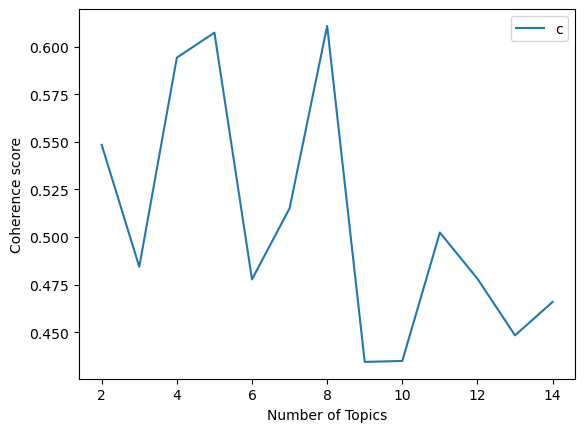

In [3]:
def load_data_from_dataframe(df, text_column, title_len = 50):
    """
    Input  : DataFrame, the name of the column containing the text and the number of words that shall be considered as the document title
    Purpose: Extract text data from a DataFrame
    Output : List of paragraphs/documents and titles (initial words considered as title of document)
    """
    documents_list = df[text_column].tolist()
    titles = [text[:min(len(text), title_len)] for text in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles


def preprocess_data(doc_set, custom_stopwords={}):
    """
    Input  : Document list, a set data type with custom_stopwords
    Purpose: Preprocess text (tokenize, remove stopwords, and stemming)
    Output : Preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    en_stop.update(custom_stopwords)
    p_stemmer = PorterStemmer()
    texts = []

    for text in doc_set:
        raw = text.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [word for word in tokens if word not in en_stop]           
        stemmed_tokens = [p_stemmer.stem(word) for word in stopped_tokens]
        texts.append(stemmed_tokens)

    return texts


def prepare_corpus(doc_clean, exclude_words=None):
    """
    Input  : Clean document
    Purpose: Create a term dictionary of our corpus and Convert a list of documents (corpus) into Document Term Matrix
    Output : Term dictionary and Document Term Matrix
    
    Before proceeding, we want to associate each word in the corpus with a unique integer ID.
    We can do this using the gensim.corpora.Dictionary class. This dictionary defines the vocabulary of all words that our processing knows about.
    """
    if exclude_words is None:
        exclude_words = []
    
    # Create the term dictionary
    dictionary = corpora.Dictionary(doc_clean)
    
    # Remove words from the dictionary
    dictionary.filter_tokens(bad_ids=[dictionary.token2id[word] for word in exclude_words if word in dictionary.token2id])
    dictionary.compactify()  # Remove gaps in id sequence after words that were removed
    
    # Convert a list of documents (corpus) into Document Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    
    return dictionary, doc_term_matrix


def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : Clean document, number of topics, and number of words associated with each topic
    Purpose: Create LSA model using gensim
    Output : Return LSA model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : Gensim dictionary, Gensim corpus, List of input texts, Max num of topics
    Purpose : Compute c_v coherence for various numbers of topics
    Output  : List of LSA topic models, Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)

    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


# Usage example:
text_column = "text"  # Specify the name of the column containing the text
documents_list, titles = load_data_from_dataframe(df, text_column)
clean_text = preprocess_data(documents_list)
start, stop, step = 2, 15, 1
plot_graph(clean_text, start, stop, step)


In [4]:
# LSA Model
number_of_topics=6
words=10
# Usage example:
text_column = "text"  # Specify the name of the column containing the text
documents_list, titles = load_data_from_dataframe(df, text_column)
clean_text = preprocess_data(documents_list)
dictionary, doc_term_matrix = prepare_corpus(clean_text)

tokens_min = 2
tokens_max = 80

#pprint.pprint(dictionary.cfs)
#pprint.pprint(dictionary.num_pos)
dictionary.filter_extremes(tokens_min, tokens_max)
#pprint.pprint(dictionary.cfs)
#pprint.pprint(dictionary.num_pos)
dictionary.token2id

Total Number of Documents: 154


{'e': 0,
 'govern': 1,
 'mode': 2,
 'cctn': 3,
 'crime': 4,
 'crimin': 5,
 'network': 6,
 'system': 7,
 'track': 8,
 '0': 9,
 'function': 10,
 'requir': 11,
 'specif': 12,
 'v1': 13,
 'home': 14,
 '1': 15,
 'area': 16,
 'critic': 17,
 'cut': 18,
 'descript': 19,
 'design': 20,
 'detail': 21,
 'edg': 22,
 'focu': 23,
 'guid': 24,
 'improv': 25,
 'investig': 26,
 'key': 27,
 'personnel': 28,
 'polic': 29,
 'principl': 30,
 'provid': 31,
 'report': 32,
 'turn': 33,
 'valu': 34,
 'version': 35,
 'overview': 36,
 'base': 37,
 'block': 38,
 'broad': 39,
 'citizen': 40,
 'differ': 41,
 'identifi': 42,
 'record': 43,
 'state': 44,
 'within': 45,
 'modul': 46,
 'applic': 47,
 'day': 48,
 'eas': 49,
 'oper': 50,
 'registr': 51,
 'act': 52,
 'approach': 53,
 'complaint': 54,
 'evid': 55,
 'exchang': 56,
 'follow': 57,
 'inform': 58,
 'interact': 59,
 'interfac': 60,
 'shall': 61,
 'take': 62,
 'effici': 63,
 'entri': 64,
 'facilit': 65,
 'initi': 66,
 'made': 67,
 'place': 68,
 'task': 69,
 'pros

In [5]:
tokens_min = 2
tokens_max = 80
model=create_gensim_lsa_model(clean_text,number_of_topics,words)


[(0, '-0.735*"user" + -0.229*"use" + -0.213*"page" + -0.160*"access" + -0.148*"inform" + -0.142*"interfac" + -0.142*"system" + -0.132*"content" + -0.127*"differ" + -0.127*"provid"'), (1, '-0.632*"page" + 0.386*"user" + -0.260*"iso" + -0.208*"9241" + -0.181*"use" + -0.115*"link" + -0.112*"guidanc" + -0.106*"applic" + -0.098*"present" + 0.098*"adapt"'), (2, '0.450*"system" + -0.365*"page" + 0.217*"function" + 0.191*"case" + 0.170*"iso" + 0.167*"must" + -0.160*"user" + 0.152*"access" + 0.149*"servic" + 0.136*"9241"'), (3, '-0.442*"iso" + -0.353*"9241" + 0.273*"system" + 0.265*"page" + 0.183*"use" + -0.178*"guidanc" + 0.171*"search" + 0.164*"case" + -0.138*"design" + -0.129*"present"'), (4, '-0.276*"servic" + -0.268*"compon" + -0.263*"function" + 0.253*"system" + -0.224*"architectur" + -0.220*"core" + -0.198*"state" + 0.182*"case" + -0.172*"custom" + -0.172*"configur"'), (5, '0.372*"use" + -0.335*"system" + 0.296*"search" + -0.250*"page" + 0.196*"polic" + -0.168*"access" + -0.151*"must" + 

In [6]:
from gensim import models

# train the model
tfidf = models.TfidfModel(clean_text)

# transform the "system minors" string
words = "system minors".lower().split()
print(tfidf[dictionary.doc2bow(words)])

ValueError: not enough values to unpack (expected 2, got 1)